In this notebook, we will implement a customized loss function. This is in order to help the NN approximate both large and small scale features. It historically has only been able to do the former. The loss function is $||u_{target}-u_{prediction}||^2 + \alpha||\nabla u_{target} - \nabla u_{prediction}||^2$. We try this with the CNN outpits being the anomaly at the SGS scale.

In [15]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from model_eval_plotting import evaluate_model
from model_eval_plotting import plot_predictions_vs_targets

from CNN_setup import SimpleCNN
from CNN_setup import TensorDataset

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [16]:
ds_HR1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_HR2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_HR3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_HR4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_HR5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_HR1, ds_HR2, ds_HR3, ds_HR4, ds_HR5]

# Concatenate along the 'time' dimension
combined_HR = xr.concat(datasets, dim='time')
combined_HR

<xarray.Dataset> Size: 109MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>

In [17]:
# Note that all this data is LR because it is filtered

ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_LR = xr.concat(datasets, dim='time')
combined_LR

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

In [18]:
combined_SGS = combined_HR - combined_LR
combined_SGS

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

In [19]:
# Total number of samples
n_samples = len(combined_HR.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_SGS = combined_SGS.isel(time=train_indices)
val_data_SGS = combined_SGS.isel(time=val_indices)
test_data_SGS = combined_SGS.isel(time=test_indices)
# LR
train_data_LR = combined_LR.isel(time=train_indices)
val_data_LR = combined_LR.isel(time=val_indices)
test_data_LR = combined_LR.isel(time=test_indices)

print("Training set size:", len(train_data_SGS.time))
print("Validation set size:", len(val_data_SGS.time))
print("Testing set size:", len(test_data_SGS.time))

Training set size: 129
Validation set size: 27
Testing set size: 29


In [20]:
# Extract HR data
## training
urel_SGS_train = train_data_SGS.u_rel.values
vrel_SGS_train = train_data_SGS.v_rel.values
sst_SGS_train = train_data_SGS.sst.values
tref_SGS_train = train_data_SGS.t_ref.values
qref_SGS_train = train_data_SGS.q_ref.values
slp_SGS_train = train_data_SGS.slp.values

## testing
urel_SGS_val = val_data_SGS.u_rel.values
vrel_SGS_val = val_data_SGS.v_rel.values
sst_SGS_val = val_data_SGS.sst.values
tref_SGS_val = val_data_SGS.t_ref.values
qref_SGS_val = val_data_SGS.q_ref.values
slp_SGS_val = val_data_SGS.slp.values

## validation
urel_SGS_test = test_data_SGS.u_rel.values
vrel_SGS_test = test_data_SGS.v_rel.values
sst_SGS_test = test_data_SGS.sst.values
tref_SGS_test = test_data_SGS.t_ref.values
qref_SGS_test = test_data_SGS.q_ref.values
slp_SGS_test = test_data_SGS.slp.values

In [21]:
# Extract LR data
## training
urel_LR_train = train_data_LR.u_rel.values
vrel_LR_train = train_data_LR.v_rel.values
sst_LR_train = train_data_LR.sst.values
tref_LR_train = train_data_LR.t_ref.values
qref_LR_train = train_data_LR.q_ref.values
slp_LR_train = train_data_LR.slp.values

## validation
urel_LR_val = val_data_LR.u_rel.values
vrel_LR_val = val_data_LR.v_rel.values
sst_LR_val = val_data_LR.sst.values
tref_LR_val = val_data_LR.t_ref.values
qref_LR_val = val_data_LR.q_ref.values
slp_LR_val = val_data_LR.slp.values

## testing
urel_LR_test = test_data_LR.u_rel.values
vrel_LR_test = test_data_LR.v_rel.values
sst_LR_test = test_data_LR.sst.values
tref_LR_test = test_data_LR.t_ref.values
qref_LR_test = test_data_LR.q_ref.values
slp_LR_test = test_data_LR.slp.values


In [22]:
# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)

# training
training_NN_inputs_urel = torch.tensor(np.stack([urel_LR_train, urel_SGS_train], axis=3))
training_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_train, vrel_SGS_train], axis=3))
training_NN_inputs_sst = torch.tensor(np.stack([sst_LR_train, sst_SGS_train], axis=3))
training_NN_inputs_tref = torch.tensor(np.stack([tref_LR_train, tref_SGS_train], axis=3))
training_NN_inputs_qref = torch.tensor(np.stack([qref_LR_train, qref_SGS_train], axis=3))
training_NN_inputs_slp = torch.tensor(np.stack([slp_LR_train, slp_SGS_train], axis=3))

# validation
val_NN_inputs_urel = torch.tensor(np.stack([urel_LR_val, urel_SGS_val], axis=3))
val_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_val, vrel_SGS_val], axis=3))
val_NN_inputs_sst = torch.tensor(np.stack([sst_LR_val, sst_SGS_val], axis=3))
val_NN_inputs_tref = torch.tensor(np.stack([tref_LR_val, tref_SGS_val], axis=3))
val_NN_inputs_qref = torch.tensor(np.stack([qref_LR_val, qref_SGS_val], axis=3))
val_NN_inputs_slp = torch.tensor(np.stack([slp_LR_val, slp_SGS_val], axis=3))

# testing
testing_NN_inputs_urel = torch.tensor(np.stack([urel_LR_test, urel_SGS_test], axis=3))
testing_NN_inputs_vrel = torch.tensor(np.stack([vrel_LR_test, vrel_SGS_test], axis=3))
testing_NN_inputs_sst = torch.tensor(np.stack([sst_LR_test, sst_SGS_test], axis=3))
testing_NN_inputs_tref = torch.tensor(np.stack([tref_LR_test, tref_SGS_test], axis=3))
testing_NN_inputs_qref = torch.tensor(np.stack([qref_LR_test, qref_SGS_test], axis=3))
testing_NN_inputs_slp = torch.tensor(np.stack([slp_LR_test, slp_SGS_test], axis=3))


### Custom loss function

In [23]:
class CNNMSEWithDerivativeLoss(nn.Module):
    def __init__(self, alpha=1.0):
        """
        Custom loss class combining MSE loss and a derivative-based regularization term.
        
        Args:
            model (nn.Module): The CNN model to use for inference.
            epsilon (float): Perturbation amount for derivative calculation.
        """
        super(CNNMSEWithDerivativeLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, outputs, targets):

        # Compute MSE loss (ensure correct shape for targets)
        mse_loss = self.mse_loss(outputs.squeeze(1), targets)
        
        # Compute the derivative-based regularization term (mean squared difference)
        # derivative_loss = find a way to properly compute this
        dx_output = torch.roll(outputs.squeeze(), shifts=-1, dims=1) - outputs.squeeze()
        dx_target = torch.roll(targets.squeeze(), shifts=-1, dims=1) - targets.squeeze()
        dy_output = torch.roll(outputs.squeeze(), shifts=-1, dims=0) - outputs.squeeze()
        dy_target = torch.roll(targets.squeeze(), shifts=-1, dims=0) - targets.squeeze()
        
        dx_derivative_loss = self.mse_loss(dx_output, dx_target)
        dy_derivative_loss = self.mse_loss(dy_output, dy_target)

        # Total loss is the sum of MSE and derivative regularization
        total_loss = mse_loss + self.alpha * dx_derivative_loss + self.alpha * dy_derivative_loss
        return total_loss


In [32]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = training_NN_inputs_urel.shape[1]
image_width = training_NN_inputs_urel.shape[2]
output_channels = 1 #output can be in grayscale, num of output channels

# Instantiate the model with the parameters
model = SimpleCNN(in_channels, image_height, image_width, output_channels)

# Check the model architecture
print(model)

# Loss criterion and optimizer
criterion = CNNMSEWithDerivativeLoss(alpha=0)  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001) #, weight_decay=0.01)

# Define the number of input channels 
input_channels = 1
train_dataset = TensorDataset(training_NN_inputs_urel, input_channels)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

val_dataset = TensorDataset(val_NN_inputs_urel, input_channels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

num_epochs = 100  # Number of epochs to train
loss_values = []  # Training loss for each epoch
val_loss_values = []  # Validation loss for each epoch

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Batch size 1 handling (inputs shape: [1, y, x, variables ])
        inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Reshape to (vars, y, x) --> CNN input expects vars/channels first
        targets = targets.squeeze(0).float()  # Shape: (y, x)
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_values.append(average_loss)

    # Validation phase: Use evaluate_model
    val_loss, _, _ = evaluate_model(model, val_loader, criterion)
    val_loss_values.append(val_loss)

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")

print("Training complete!")

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)
Epoch [1/100], Training Loss: 0.1539, Validation Loss: 0.1845
Epoch [2/100], Training Loss: 0.1473, Validation Loss: 0.1827
Epoch [3/100], Training Loss: 0.1451, Validation Loss: 0.1824
Epoch [4/100], Training Loss: 0.1422, Validation Loss: 0.1811
Epoch [5/100], Training Loss: 0.1409, Validation Loss: 0.1781
Epoch [6/100], Training Loss: 0.1372, Validation Loss: 0.1756
Epoch [7/100], Training Loss: 0.1354, Validation Loss: 0.1742
Epoch [8/100], Training Loss: 0.1335, Validation Loss: 0.1732
Epoch [9/100], Training Loss: 0.1312, Validation Loss: 0.1774
Epoch [10/100], Training Loss: 0.1308, Validation Loss: 0.1727
Epoch [1

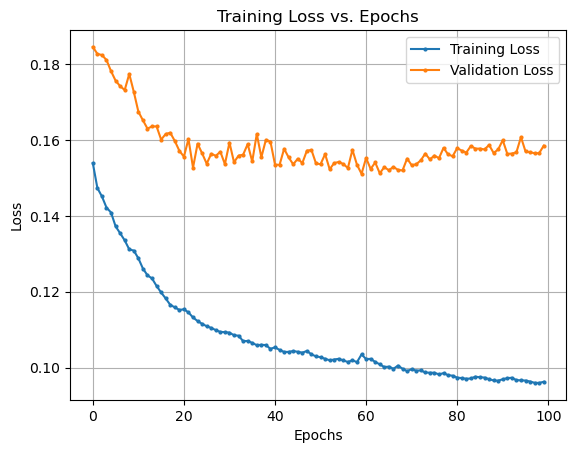

In [33]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')
plt.plot(epochs_plot, val_loss_values, marker='o', markersize=2, label='Validation Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

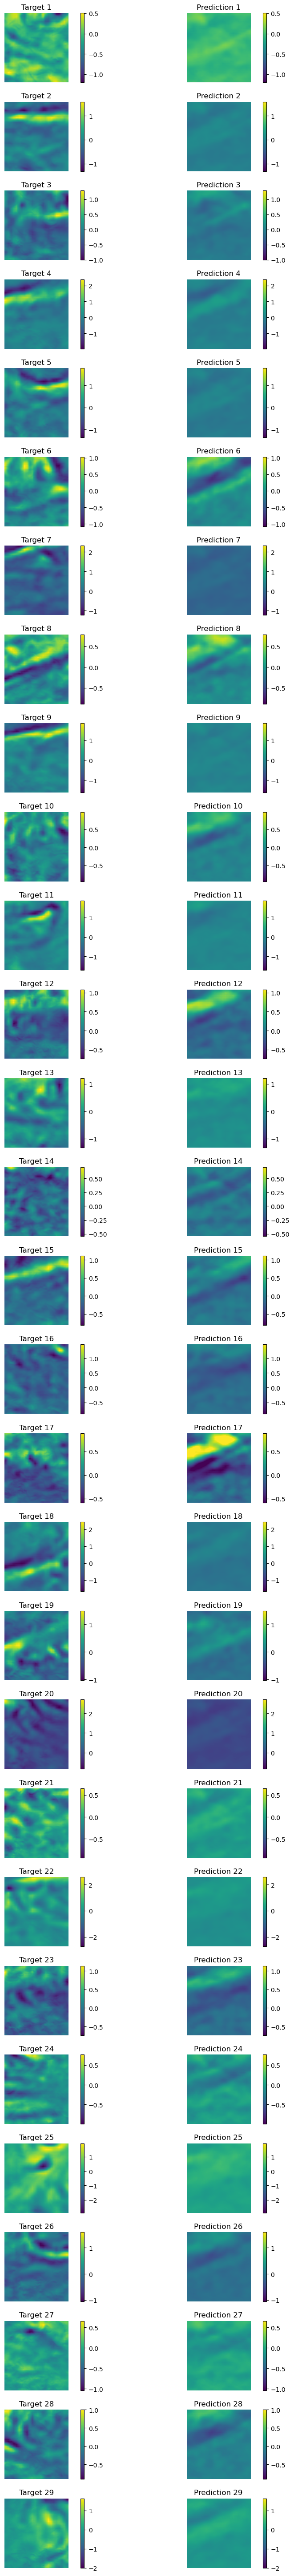

In [34]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs_urel, input_channels)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

# Define your criterion (loss function)
criterion = CNNMSEWithDerivativeLoss(alpha=0)  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=len(test_data_LR.time))  # Change num_samples as needed

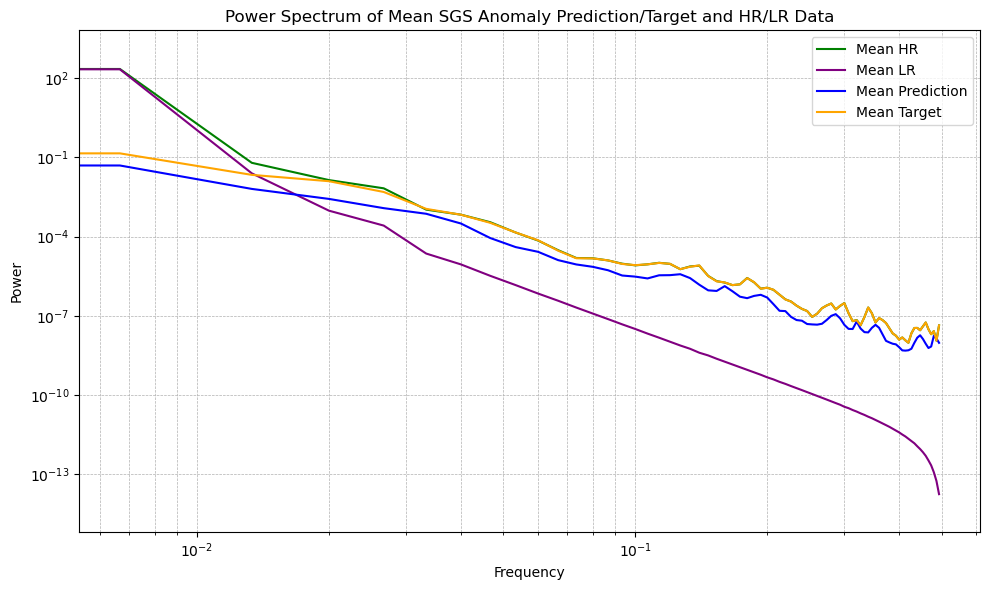

In [35]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(predictions.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(predictions.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
test_data_LR = combined_LR.isel(time=test_indices)
urel_LR_test = test_data_LR.u_rel
mean_LR = urel_LR_test.mean(dim='time').values
test_data_HR = combined_HR.isel(time=test_indices)
urel_HR_test = test_data_HR.u_rel
mean_HR = urel_HR_test.mean(dim='time').values
mean_prediction = predictions.squeeze(1).mean(dim=0)  # Squeeze to remove the channel dimension and compute mean
mean_target = targets.mean(dim=0)

# Convert to xarray.DataArray
mean_LR_da = xr.DataArray(mean_LR, dims=dims, coords=coords)
mean_HR_da = xr.DataArray(mean_HR, dims=dims, coords=coords)
mean_prediction_da = xr.DataArray(mean_prediction.numpy(), dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target.numpy(), dims=dims, coords=coords)

# Compute power spectrum for mean prediction and target
ps_LR = xrft.power_spectrum(mean_LR_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_HR = xrft.power_spectrum(mean_HR_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='Mean HR', color='green')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='Mean LR', color='purple')
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean SGS Anomaly Prediction/Target and HR/LR Data")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()
